Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Download dataset

In [17]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Load dataset

In [18]:
df = pd.read_csv(csv_path)
df = df[5::6] #This gives you hourly data (its every 10 min by default)

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Visualise the dataset

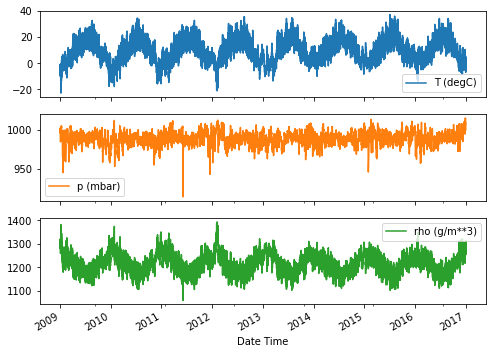

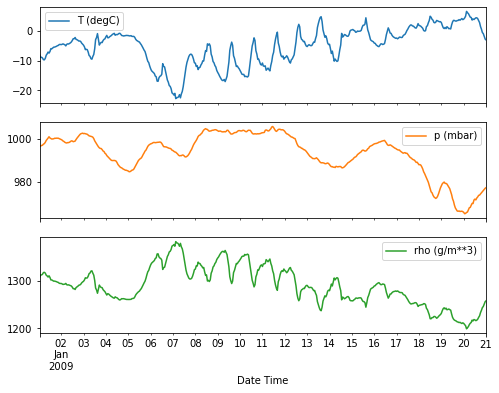

In [9]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Inspect the data statistically and resolves errors

In [19]:
#Wind can't have a min value of -9999 m/s, so set all those values to 0

wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
df['wv (m/s)'].min()

df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Wind

Degrees are not very useful, because 0 and 360 are next to each other, but it
won't know this. Instead convert the wind to vectors

In [20]:
#get columns
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)')*np.pi / 180 #convert to radians

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-19.64147299215435,
 11.913133039539135,
 -14.88336704201272,
 14.302308062832465)

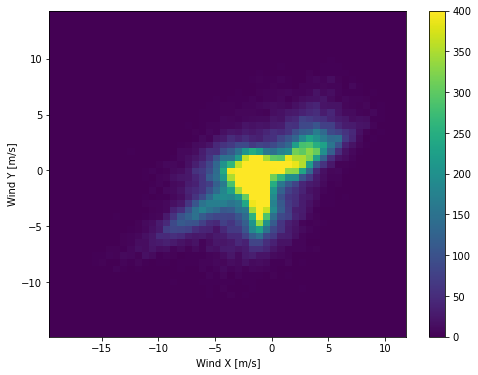

In [22]:
plt.hist2d(df['max Wx'], df['max Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Similarly time is useful, but not in string format

In [26]:
day = 24*60*60
year = (365.2425)*day

timestamp_s = date_time.map(pd.Timestamp.timestamp)

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

'''
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')'''

"\nplt.plot(np.array(df['Day sin'])[:25])\nplt.plot(np.array(df['Day cos'])[:25])\nplt.xlabel('Time [h]')\nplt.title('Time of day signal')"

In [30]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

val_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
294383,990.43,14.46,288.41,13.81,95.9,16.49,15.82,0.68,9.99,15.97,1192.35,-0.448741,-1.389328,-0.682332,-2.112540,0.537300,8.433914e-01,-0.549225,-0.835674
294389,990.66,13.83,287.76,13.39,97.2,15.83,15.39,0.44,9.72,15.53,1195.44,-0.449278,-0.756670,-0.714760,-1.203793,0.737277,6.755902e-01,-0.549824,-0.835280
294395,990.80,13.53,287.45,13.31,98.6,15.53,15.31,0.22,9.67,15.45,1196.90,-1.518657,0.592100,-2.608735,1.017103,0.887011,4.617486e-01,-0.550423,-0.834886
294401,990.96,13.33,287.24,13.16,98.9,15.33,15.16,0.17,9.57,15.29,1198.00,-0.768007,-0.855958,-1.175385,-1.309988,0.976296,2.164396e-01,-0.551021,-0.834491
294407,991.10,13.46,287.35,13.35,99.3,15.46,15.35,0.11,9.69,15.49,1197.54,-1.443201,-0.220841,-2.253766,-0.344875,0.999048,-4.361939e-02,-0.551619,-0.834096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378461,1000.67,2.98,276.09,0.81,85.6,7.57,6.48,1.09,4.04,6.48,1259.29,3.376647,1.911193,4.917024,2.783051,-0.707107,-7.071068e-01,0.936418,0.350886
378467,1000.67,2.93,276.03,1.14,88.0,7.54,6.64,0.90,4.13,6.63,1259.47,2.794019,1.432850,4.742714,2.432194,-0.866025,-5.000000e-01,0.936670,0.350214
378473,1000.91,2.29,275.38,1.02,91.3,7.21,6.58,0.63,4.10,6.57,1262.71,3.161342,2.840496,4.172971,3.749455,-0.965926,-2.588190e-01,0.936920,0.349543
378479,1001.13,2.48,275.56,1.19,91.1,7.31,6.66,0.65,4.15,6.65,1262.05,3.065617,1.667960,3.944018,2.145885,-1.000000,7.614762e-13,0.937171,0.348871


Normalise the data.


In [31]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Examine the distribution of features. Some have long tails

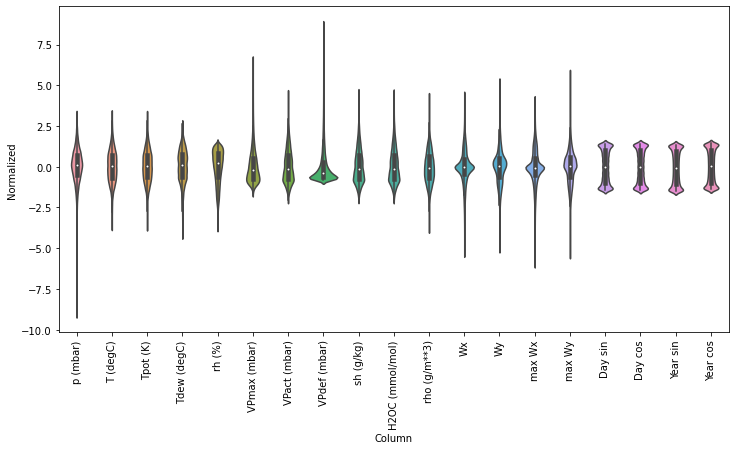

In [33]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Data windowing

In [34]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [37]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']